### Importação das Bibliotecas Externas

In [691]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.colors import Colormap 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

## Descrição do Conjunto de Dados

O dataset selecionado possui como objetivo a classificação e predição de remédios para pacientes. Possuindo como atributos a idade, sexo, pressão sanguínea, nível de cloresterol e a relação sódio/potássio no sangue. Por fim, a classe é o remédio a ser escolhido dentre as 5 opções disponíveis.
Uma característica interessante do dataset escolhido é a variedade entre os tipos de atributos presentes:
    
- Idade: Atributo Numérico/Quantitativo
- Sexo, Pressão Sanguínea e Cloresterol: Atributos Nominais
- Sódio/Potássio: Atributo Contínuo

### Leitura dos dados

In [692]:
drug_dataset = pd.read_csv("drug200.csv")
drug_dataset.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


### Análise Exploratória dos Dados

Nessa etapa, foram elaborados gráficos e figuras que permitem uma melhor comprensão sobre a distribuição dos dados dentro do conjunto.

Os remédios Y e X são os mais utilizados, enquanto A, B e C tem uma utilização bem mais reduzida

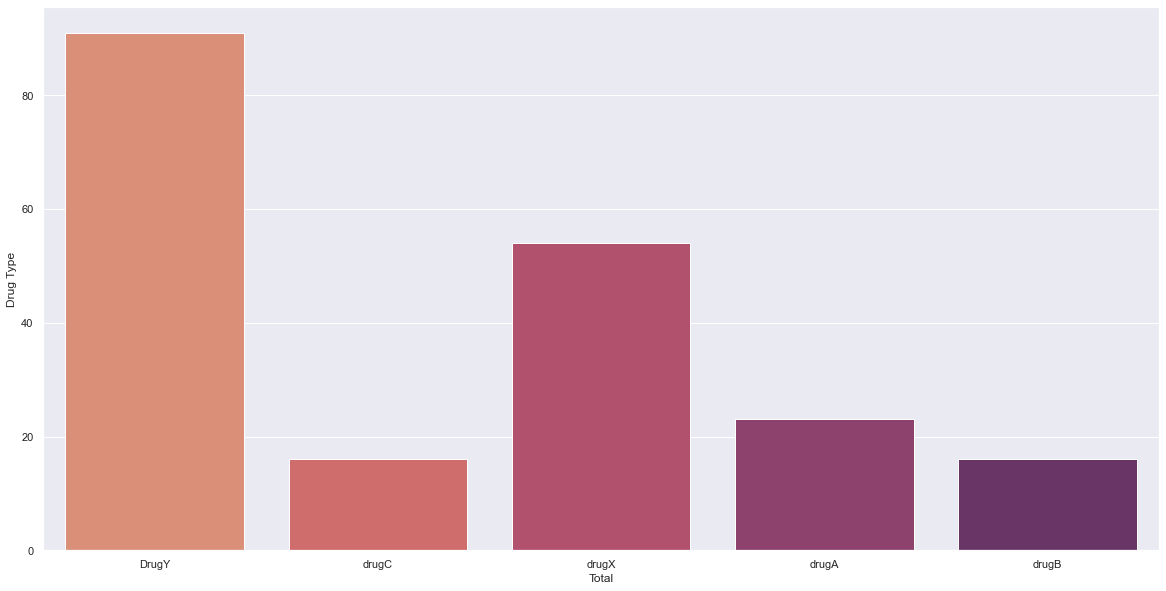

In [693]:
plt.figure(figsize= [20,10])
sns.countplot(x="Drug", data=drug_dataset, palette="flare")
plt.ylabel('Drug Type')
_ = plt.xlabel('Total')

Já o nível de cloresterol no sangue dos pacientes é mais equilibrado, sendo a quantidade de pacientes com alto nível de cloresterol um pouco maior que a de pacientes com um nível definido como normal.

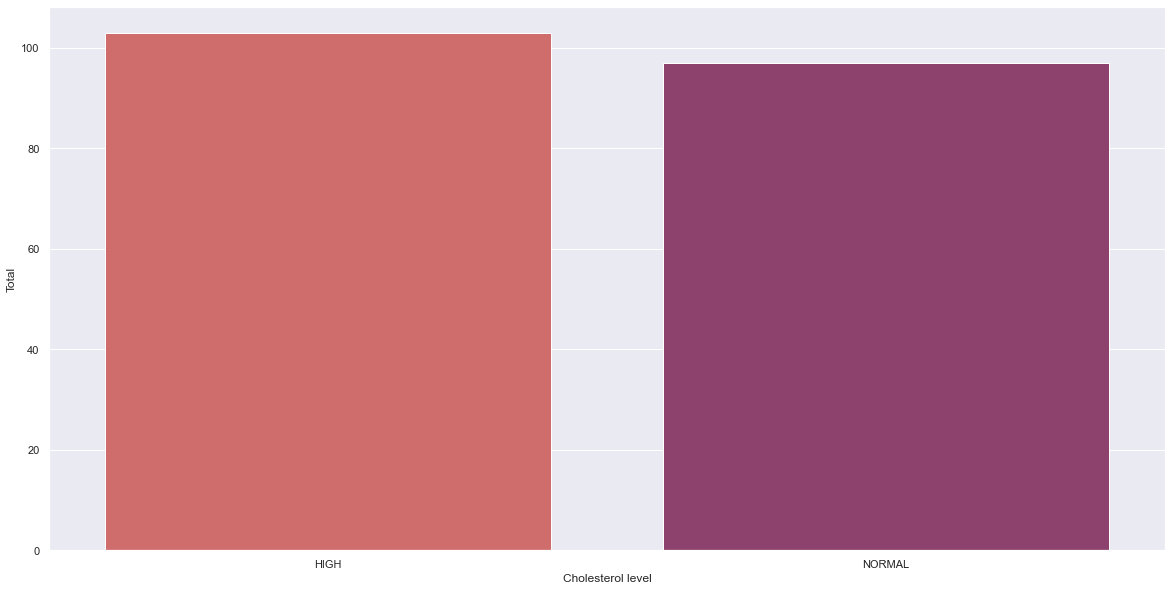

In [694]:
plt.figure(figsize= [20,10])
sns.countplot(x="Cholesterol", data=drug_dataset, palette="flare")
plt.xlabel('Cholesterol level')
_ = plt.ylabel('Total')

O sexo dos pacientes também é bem distribuído dentro do conjunto, com uma pequena vantagem no número de pacientes do sexo masculino.

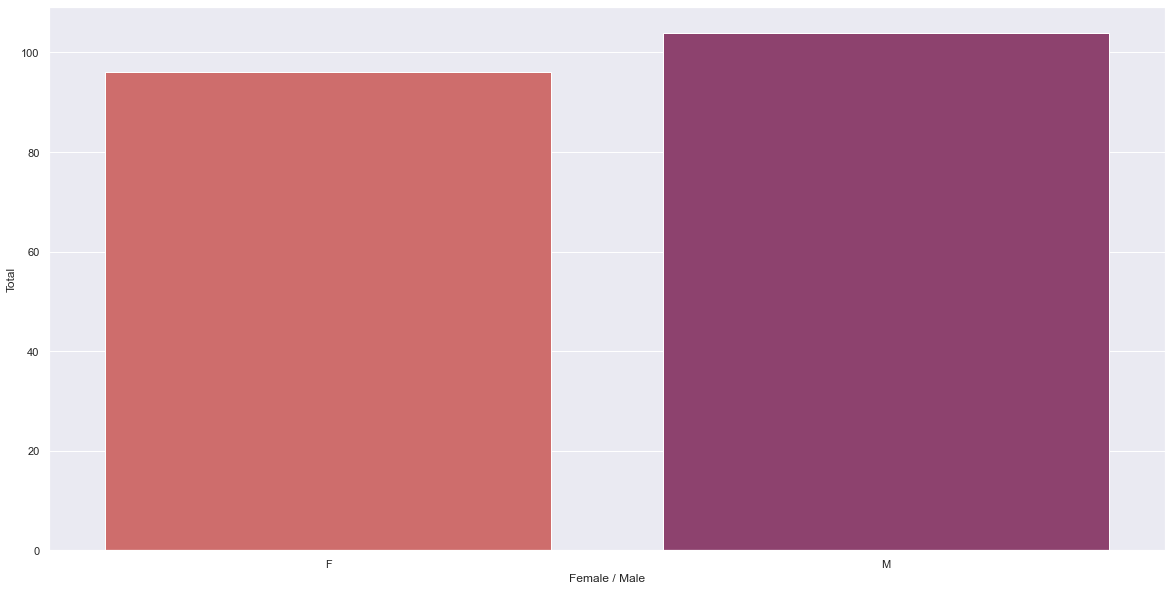

In [695]:
plt.figure(figsize= [20,10])
sns.countplot(x="Sex", data=drug_dataset, palette="flare")
plt.xlabel('Female / Male')
_ = plt.ylabel('Total')

Já na Pressão Sanguínea, pode se observar que uma pequena parte dos pacientes está com um nível normal, e dominam os pacientes com níveis altos ou baixos.

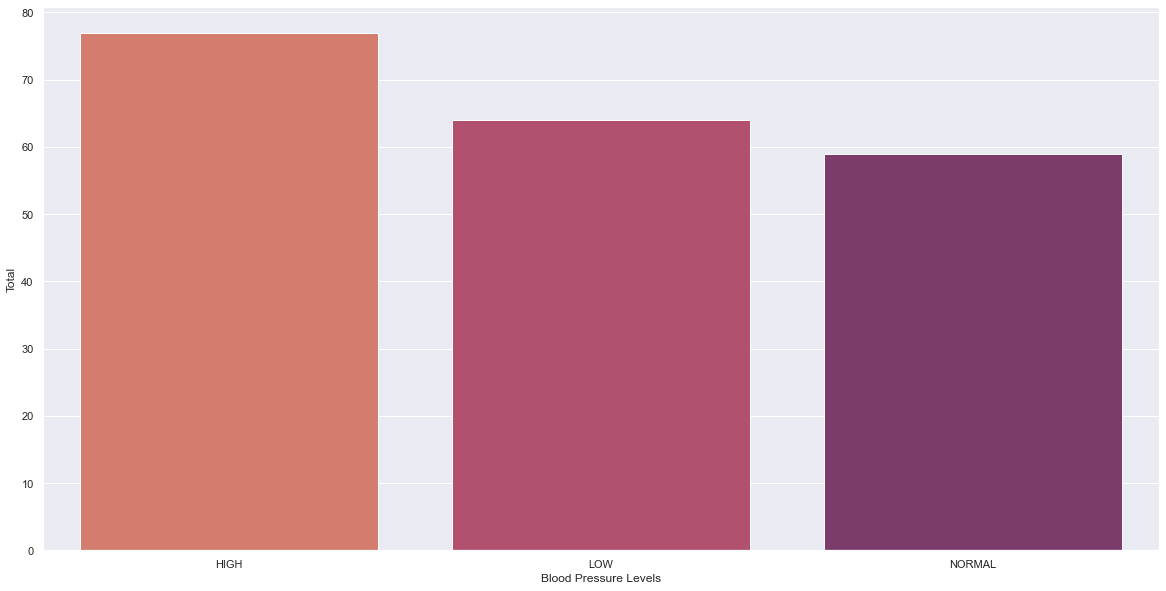

In [696]:
plt.figure(figsize= [20,10])
sns.countplot(x="BP", data=drug_dataset, palette="flare")
plt.xlabel('Blood Pressure Levels')
_ = plt.ylabel('Total')

Nos próximos gráficos podemos perceber a proporção dos pacientes em relação à proporção Sódio/Potássio e também em relação à idade.
No caso da Relação Sódio/Potássio, há uma predominância nos níveis próximos de 10. E em relação à Idade, vemos uma maioria em torno da faixa dos 40 anos.

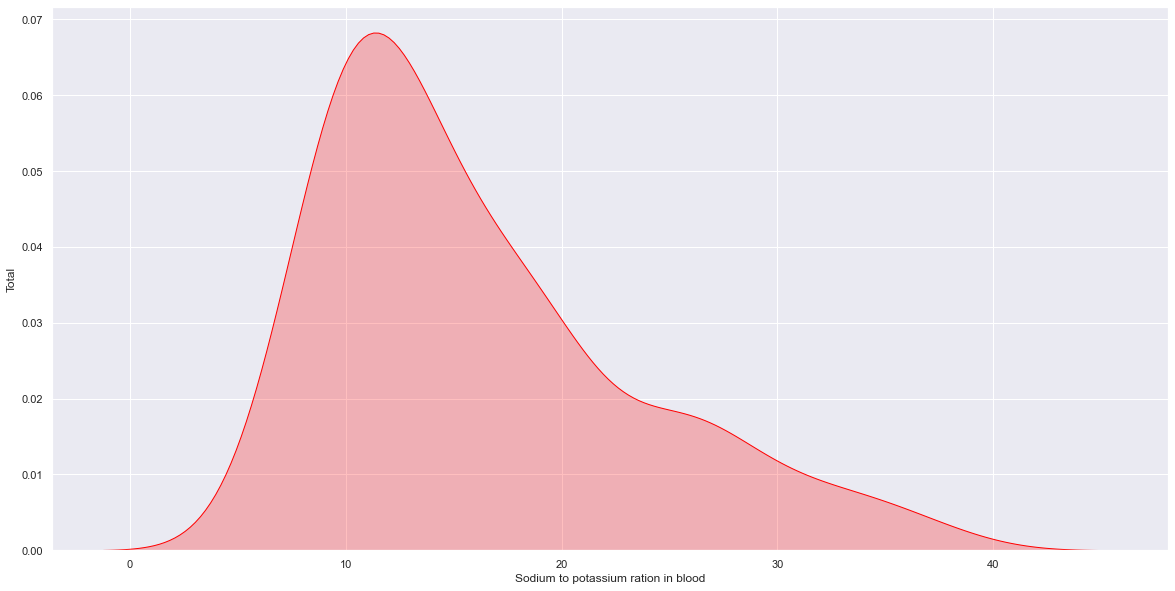

In [697]:
plt.figure(figsize= [20,10])
sns.kdeplot(drug_dataset["Na_to_K"], color = 'red', fill = True)
plt.xlabel('Sodium to potassium ration in blood')
_ = plt.ylabel('Total')

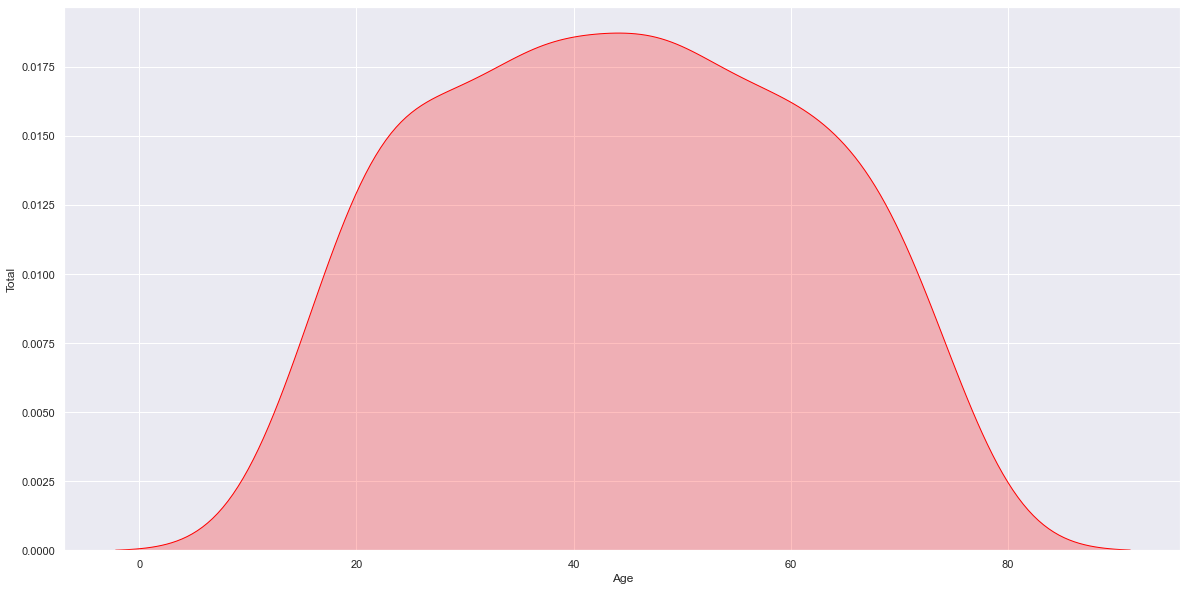

In [698]:
plt.figure(figsize= [20,10])
sns.kdeplot(drug_dataset["Age"], color = 'red', fill = True)
plt.xlabel('Age')
_ = plt.ylabel('Total')

Por fim, temos o Boxplot dos mesmos dois atributos anteriores, onde pode-se notar a presença de alguns outliers no Atributo Relação Sódio/Potássio.

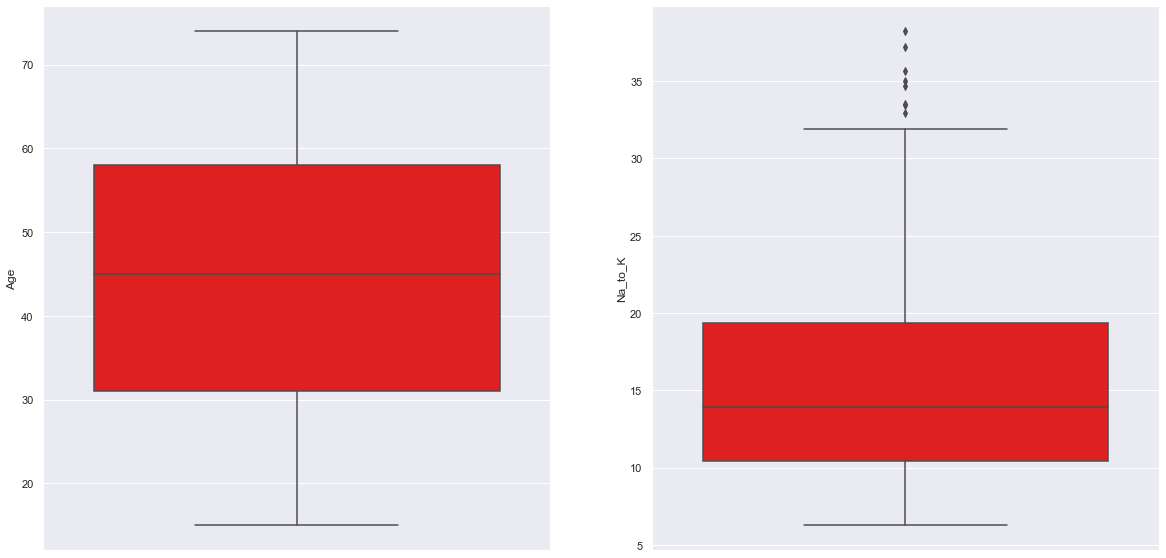

In [699]:
plt.figure(figsize= [20,10])
plt.title('Boxplot das variáveis contínuas')
plt.subplot(1, 2, 1)
sns.boxplot(y=drug_dataset["Age"], color = 'red')
plt.subplot(1, 2, 2)
_ = sns.boxplot(y=drug_dataset["Na_to_K"], color = 'red')

### Pré-processamento universal dos dados

Por conta dos diferentes tipos de atributos presentes no conjunto, é necessário realizar um pré-processamento dos dados para que os algoritmos escolhidos possam funcionar sem maiores problemas.
Primeiro foi utilizada a técnica de Label Encoder para o tratamento dos atributos nominais, transformando as strings em números.

In [700]:
def pre_process(dataset, std_scaler = False):
  X = dataset.drop('Drug', axis=1)
  y = dataset['Drug']

  le = LabelEncoder()

  X = X.apply(LabelEncoder().fit_transform)
  y = le.fit_transform(y)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  
  if std_scaler:
    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)
    
  return X_train, X_test, y_train, y_test

### Pré-processamento adicional

Um segundo tipo de pré-processamento utilizado foi a remoção dos outliers, no entanto, esse método foi aplicado com a intenção de ser um pré-processamento adicional. Dessa maneira, os algoritmos de Aprendizado de máquina foram aplicados no dataset antes e depois da remoção dos outliers para permitir a comparação dos resultados e por fim determinar se foi vantajoso.

In [701]:
def additional_pre_process(dataset, drop_outliers = False, balance_target = False):  
  if drop_outliers:
    dataset = dataset.drop(dataset[dataset['Na_to_K'] > 32].index)
  
  if balance_target: 
    dataset_a = dataset[dataset['Drug'] == 'drugA']
    dataset_b = dataset[dataset['Drug'] == 'drugB']
    dataset_c = dataset[dataset['Drug'] == 'drugC']
    dataset_x = dataset[dataset['Drug'] == 'drugX']

    dataset = pd.concat([dataset, dataset_a, dataset_a, dataset_a])
    dataset = pd.concat([dataset, dataset_b, dataset_b, dataset_b, dataset_b])
    dataset = pd.concat([dataset, dataset_c, dataset_c, dataset_c, dataset_c])
    dataset = pd.concat([dataset, dataset_x])
    
  return dataset

### Métricas e matriz de confusão

In [702]:
def metrics_cf(y_test, y_pred):
  metrics = classification_report(y_test, y_pred)

  c_matrix = confusion_matrix(y_test, y_pred)

  return metrics, c_matrix

In [703]:
def plot_cf(c_matrix, classifier):
  
  class_names = ['DrugY', 'DrugA', 'DrugB', 'DrugC', 'DrugX']
  fig, ax = plot_confusion_matrix(conf_mat=c_matrix,
                                  show_absolute=True,
                                  colorbar=True, 
                                  class_names=class_names, 
                                  figsize=(10, 10));
  
  plt.title('Confusion Matrix - %s ' % classifier)
  _ = plt.savefig('confusion_matrix_%s.png' % classifier, dpi=fig.dpi);
  
  plt.show();


### Generização do treino e teste dos modelos

In [704]:
def train_test_classifier(dataset, dec_tree = False, gauss_nb = False, knn = False, drop_outliers = False, balance_target = False, n_neighbors=5):
  
  # Aplicando pre-processamento adicional caso determinado
  dataset = additional_pre_process(dataset, drop_outliers, balance_target)
  
  if dec_tree:
    # Preparando os dados
    X_train, X_test, y_train, y_test = pre_process(dataset = dataset)
    
    
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Gera as metricas do classifiero
    metrics, c_matrix, = metrics_cf(y_test, y_pred)
    
    return classifier, metrics, c_matrix
  
  elif gauss_nb:
    # Preparando os dados
    X_train, X_test, y_train, y_test = pre_process(dataset, std_scaler=True)
    
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Gera as metricas do classifiero
    metrics, c_matrix, = metrics_cf(y_test, y_pred)
    
    return classifier, metrics, c_matrix
    
  elif knn:
    # Preparando os dados
    X_train, X_test, y_train, y_test = pre_process(dataset, std_scaler=True)
    
    classifier = KNeighborsClassifier(n_neighbors = n_neighbors)
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Gera as metricas do classifiero
    metrics, c_matrix, = metrics_cf(y_test, y_pred)
    
    return classifier, metrics, c_matrix

### Decision Tree

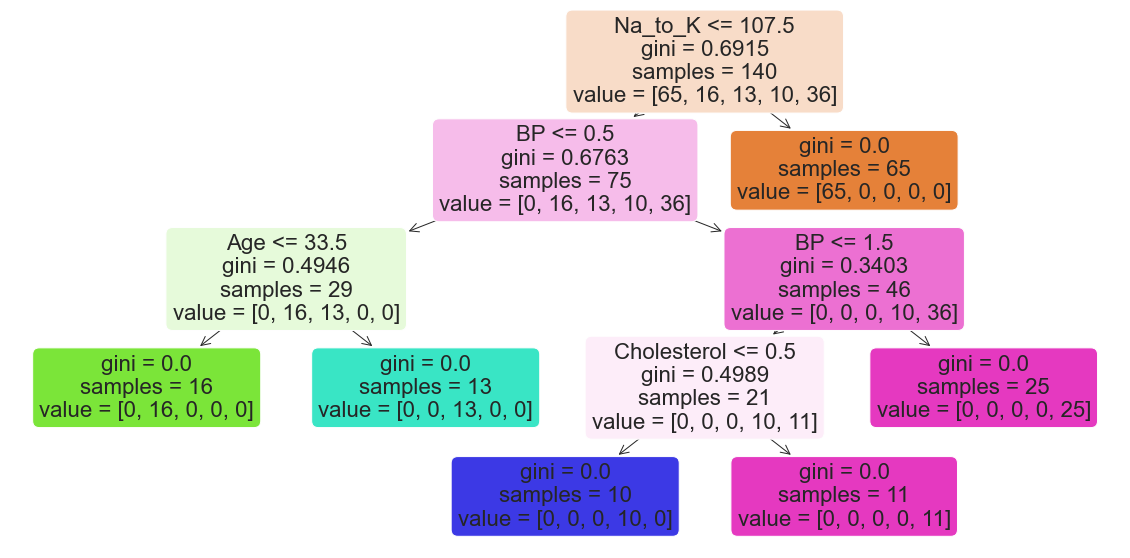

In [705]:
tree_classifier, tree_metrics, tree_c_matriz = train_test_classifier(dataset=drug_dataset, dec_tree = True)

# Plotando a arvores gerada
plt.figure(figsize = (20,10))
decision_tree = plot_tree(decision_tree=tree_classifier, 
                          feature_names = drug_dataset.columns, 
                          filled = True , 
                          precision = 4, 
                          rounded = True)

### Resultados Obtidos

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        18

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



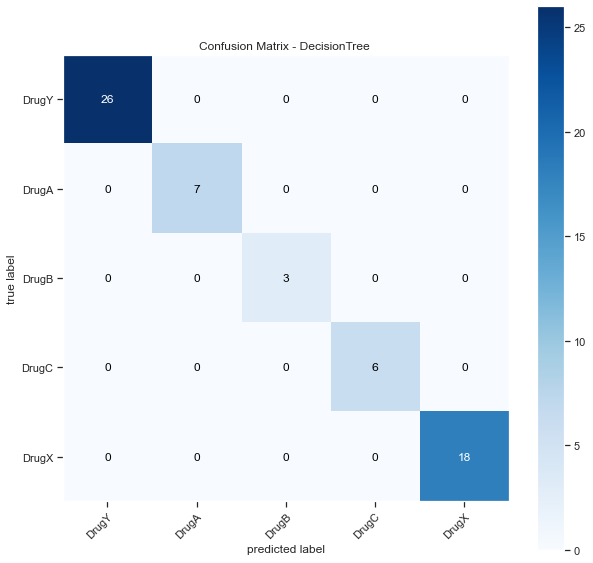

In [706]:
print(tree_metrics)
plot_cf(tree_c_matriz, classifier='DecisionTree')

### KNN

In [707]:
knn_classifier, knn_metrics, knn_c_matriz = train_test_classifier(dataset=drug_dataset, knn = True)

### Resultados KNN

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        26
           1       1.00      1.00      1.00         7
           2       0.60      1.00      0.75         3
           3       1.00      0.17      0.29         6
           4       0.94      0.94      0.94        18

    accuracy                           0.88        60
   macro avg       0.88      0.81      0.78        60
weighted avg       0.90      0.88      0.86        60



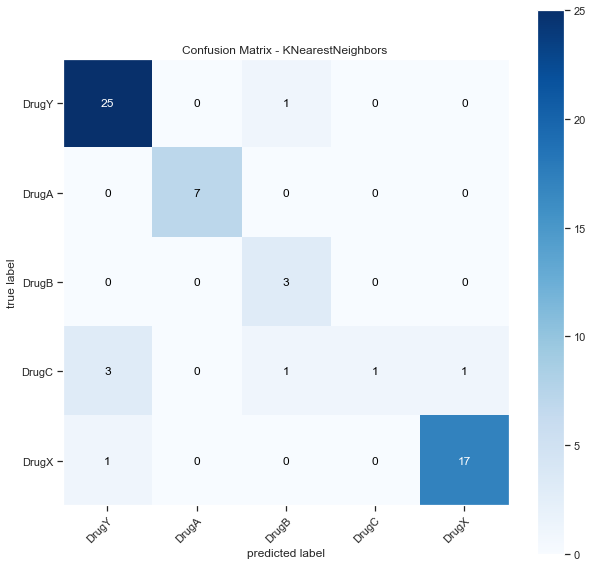

In [708]:
print(knn_metrics)
plot_cf(knn_c_matriz, classifier='KNearestNeighbors')

### Naive Bayes

In [709]:
gauss_nb_classifier, gauss_nb_metrics, gauss_nb_c_matriz = train_test_classifier(dataset=drug_dataset, gauss_nb = True)

g_nb_app_classifier, g_nb_app_metrics, g_nb_app_c_matriz = train_test_classifier(dataset=drug_dataset, gauss_nb = True, drop_outliers=True, balance_target=True)

### Resultados Naives Bayes

Gaussian Naives Bayes
              precision    recall  f1-score   support

           0       1.00      0.58      0.73        26
           1       0.64      1.00      0.78         7
           2       0.50      1.00      0.67         3
           3       0.60      1.00      0.75         6
           4       1.00      1.00      1.00        18

    accuracy                           0.82        60
   macro avg       0.75      0.92      0.79        60
weighted avg       0.89      0.82      0.82        60
 

Gaussian Naives Bayes with additional pre-process
              precision    recall  f1-score   support

           0       0.83      0.40      0.54        25
           1       0.64      1.00      0.78        23
           2       0.96      0.96      0.96        26
           3       0.89      1.00      0.94        17
           4       1.00      0.95      0.98        42

    accuracy                           0.86       133
   macro avg       0.87      0.86      0.84       133
wei

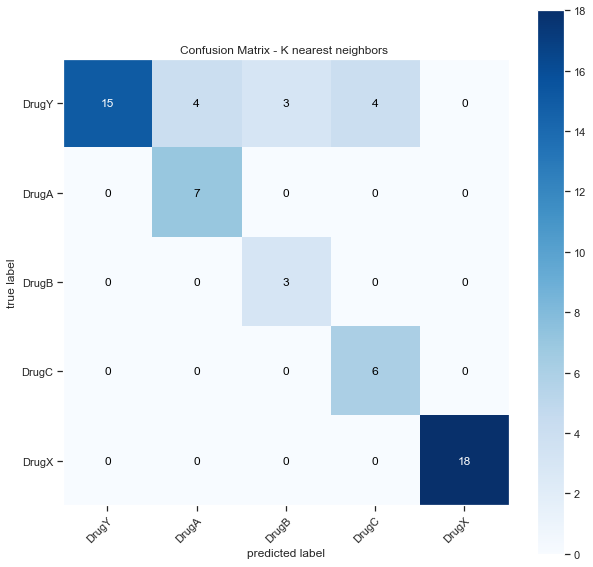

Gaussian Naives Bayes with additional pre-process - Confusion Matrix


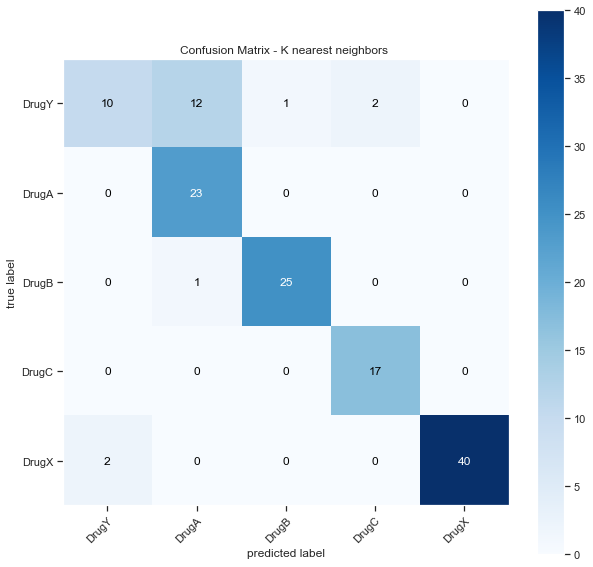

In [710]:
print('Gaussian Naives Bayes')
print(gauss_nb_metrics, '\n')

print('Gaussian Naives Bayes with additional pre-process')
print(g_nb_app_metrics, '\n')

print('Gaussian Naives Bayes - Confusion Matrix')
plot_cf(gauss_nb_c_matriz, classifier='K nearest neighbors')

print('Gaussian Naives Bayes with additional pre-process - Confusion Matrix')
plot_cf(g_nb_app_c_matriz, classifier='K nearest neighbors')